Obtain data for forecasts

-
- plot analytic latent distribution for each vehicle
- plot predictions on map
- plot predictions color coded to latent values
- saves a map to overlay trajectory data
- saves all trajectory data in this format:

```
{
    latent_colors: <array of RGBA (red, green, blue, alpha) tuples of float values in closed interval [0, 1]>
    n_vehicles: <number of vehicles in sample>
    scene: <scene ID>
    timestep: <timestep of sample>
    prediction_horizon: <prediction horizon; number of points in prediction and ground truth trajectories>
    patch_extent: <the extent (min_x, min_y, max_x, max_y) the map covers (in same metric as trajectories)>
    patch_px_size: <pixel (width, height) of PNG map>
    vehicles: [
        {
            node_id: <node ID>
            ground_truth: <ground truth trajectory. (prediction_horizon, 2) dimensional>
            past: <past trajectory. (prediction_horizon, 2) dimensional>
            latent_pmf: <values of prob. mass function (PMF) of latent variable. latent_pmf[i] is the prob. of variable taking on value i>
            latent_predictions: [
                {
                    predictions: <a list of trajectories. Each trajectory is (prediction_horizon, 2) dimensional>
                },
                ... <latent_predictions[i] corresponds to each latent value i>
            ]
        },
        ...
    ]
}
```

In [1]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

class NumpyEncoder(json.JSONEncoder):
    """
    Custom encoder for numpy data types obtained from
    https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
    """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

In [2]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [3]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [4]:
# Load model
log_dir = './models'

# for provided, use ts=12
# model_name = 'int_ee_me'

# compute canada full trained
# prediction horizon 8
model_name = 'models_19_Mar_2021_22_14_19_int_ee_me_ph8'

# compute canada full trained
# model_name = 'models_17_Mar_2021_19_20_17_int_ee'

# compute canada full trained
# must set waypoint for robot?
# model_name = 'models_17_Mar_2021_19_17_00_robot'

model_dir = os.path.join(log_dir, model_name)
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=20)


Loading from ./models/models_19_Mar_2021_22_14_19_int_ee_me_ph8/model_registrar-20.pt
Loaded!



### Combining forecast and map

In [5]:
def sample_1():
    """Bi-modality at intersection turn left or right"""
    return eval_scenes[25], 11

def sample_2():
    """Two cars moving into the same 1-way lane"""
    return get_scene('907'), 5

def sample_3():
    """T-intersection, car does not have much history"""
    return get_scene('1066'), 13

def sample_4():
    """Two parallel cars moving into a lane"""
    return get_scene('1073'), 5

def sample_5():
    """Two perpendicular cars moving into a lane.
    Car moving straight yields to turning car"""
    # send to Heejin
    return get_scene('103'), 10

def sample_6():
    """Car parks in front of of merge lane.
    Car in merge lane must avoid the parking car"""
    return get_scene('344'), 15

def sample_7():
    """Roundabout"""
    # send to Heejin
    return get_scene('523'), 17

def sample_8():
    """Two cars turning at stop sign.
    Not immediately clear who will turn."""
    # send to Heejin
    return get_scene('556'), 6

scene, t = sample_7()

ph = 8
num_samples = 100
timesteps = np.array([t])

[Scene: Duration: 19.5s, Nodes: 20, Map: Yes.]


8 Vehicles
Map centered on node VEHICLE/ego


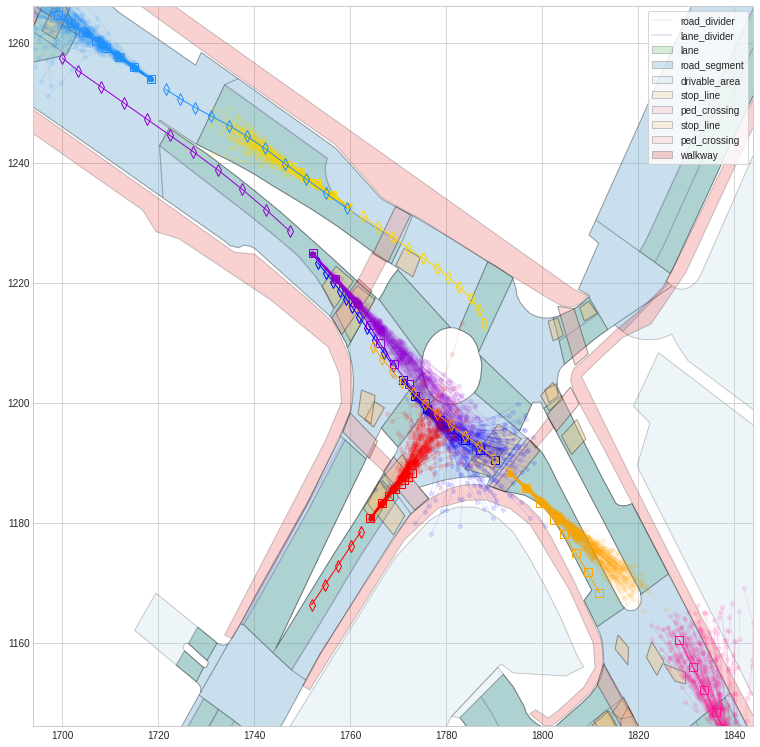

In [6]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
# node = next(filter(lambda k: 'ego' in repr(k), v_nodes))
node = v_nodes[0]

print(f"{len(v_nodes)} Vehicles")
print("Map centered on node", node)

minpos = np.array([scene.x_min, scene.y_min])
ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = np.array([
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty])

center = minpos + ego_lastpos
viewport_hw = 50
patch_extent = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)
if scene.map_name != nusc_map.map_name:
    nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=scene.map_name)
fig, ax = nusc_map.render_map_patch(patch_extent, scene.layer_names,
        figsize=(10, 10), alpha=0.2, render_egoposes_range=False)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]
    player_future += minpos
    player_past += minpos
    player_predict += minpos

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

fn = f"predict_scene{scene.name}_t{timesteps[0]}_overhead.png"
fp = os.path.join('plots', fn)
fig.savefig(fp)

### Latents to forecasts

### Plot predictions by latent

In [7]:
def generate_vehicle_latents(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)

    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
#     print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
#     print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict, latent_probs

def plot_behavior(z, predictions, nodes):
    coords = predictions.reshape(-1, 2)
    x_max, y_max = np.amax(coords, axis=0)
    x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
    figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, 25))
    fig, axes = plt.subplots(13, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, 25):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
    axes[-1,-1].set_xlim([x_min, x_max])
    axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_visible(False)
    return fig, axes

In [8]:
z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
        num_samples=500,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

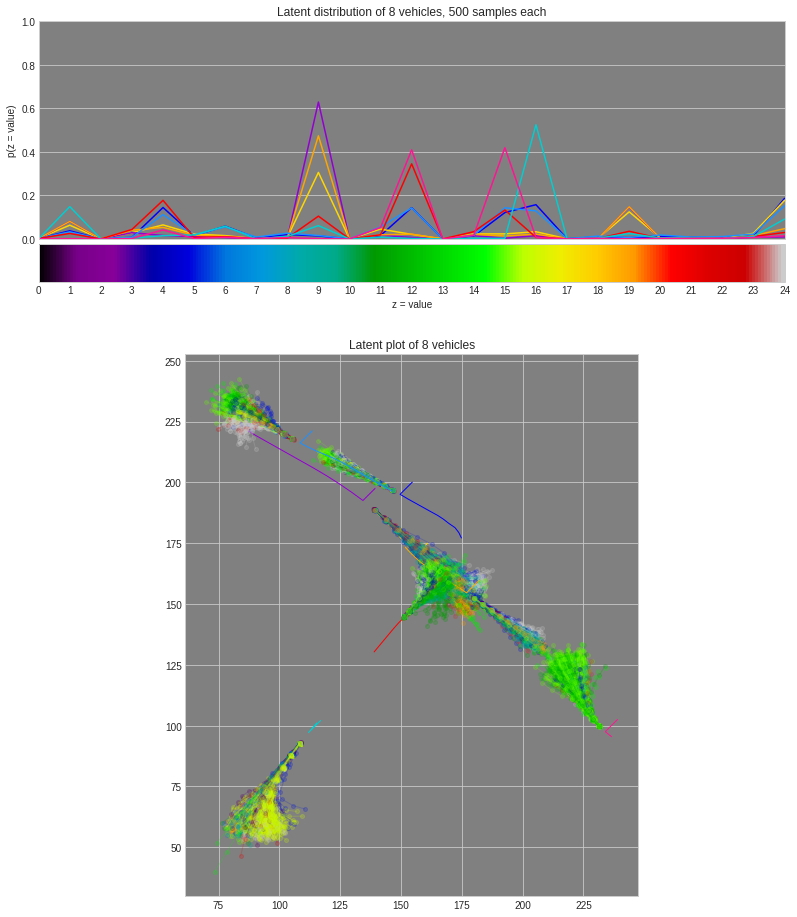

In [9]:
colors = cm.nipy_spectral(np.linspace(0, 1, 25))
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(latent_probs):
    ax1.plot(range(25), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')

for idx, node in enumerate(nodes):
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    # latent variable z corresponding to vehicle.
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

fn = f"predict_scene{scene.name}_t{timesteps[0]}_comb_latents.png"
fp = os.path.join('plots', fn)
fig.savefig(fp)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


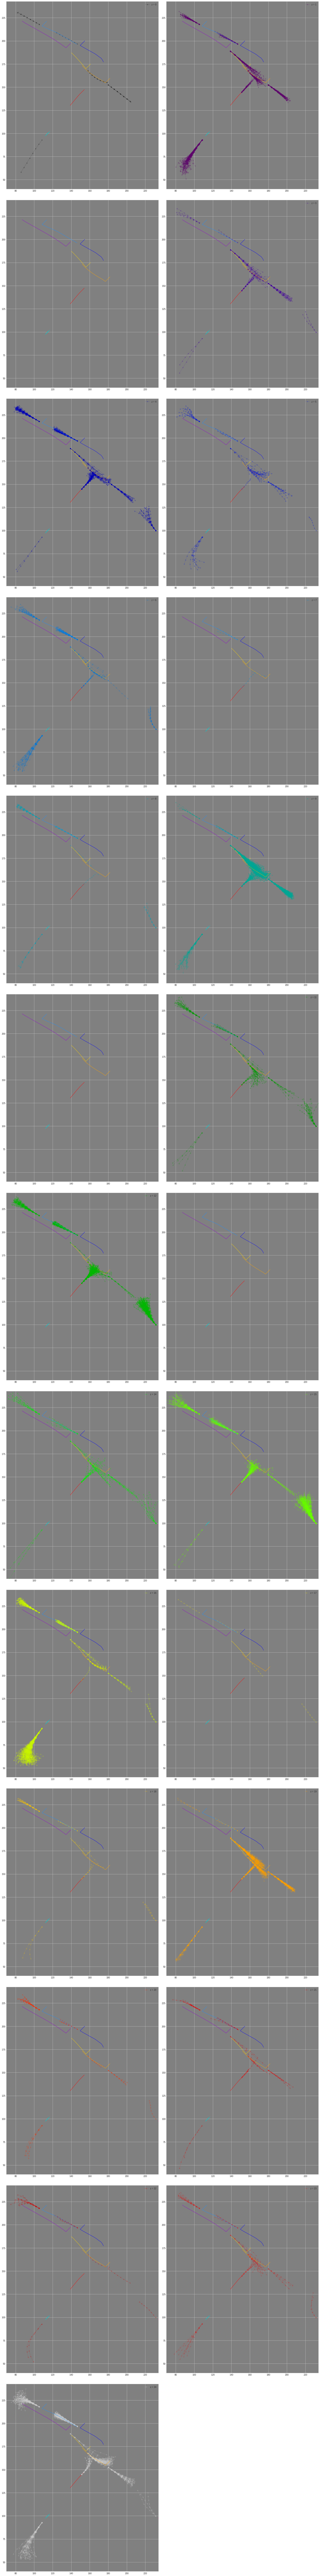

In [10]:
fig, ax = plot_behavior(z, predictions, nodes)
fn = f"predict_scene{scene.name}_t{timesteps[0]}_each_latents.png"
fp = os.path.join('plots', fn)
fig.savefig(fp)

### Save map section and obtain dimensions

Map is centered on node VEHICLE/ego


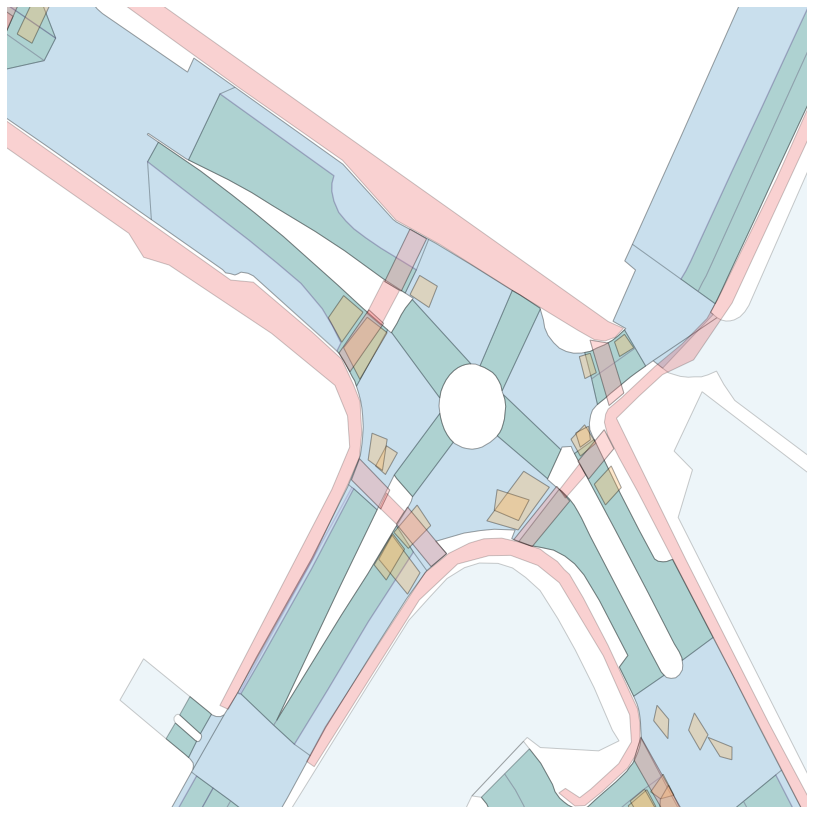

In [11]:
_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

node = get_ego_node(nodes)
print("Map is centered on node", node)

# get map positional data
minpos = np.array([scene.x_min, scene.y_min])
ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = np.array([
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty])
center = minpos + ego_lastpos
viewport_hw = 50
patch_extent = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)

if scene.map_name != nusc_map.map_name:
    nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=scene.map_name)

# set the figure size in pixels
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
patch_px_size = np.array([800, 800])
figsize = patch_px_size * px

# API from
# https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/map_expansion/map_api.py
fig, ax = nusc_map.render_map_patch(patch_extent, scene.layer_names,
        figsize=figsize, alpha=0.2, render_egoposes_range=False, render_legend=False)

fig.gca().set_axis_off()
fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())
fn = f"predict_scene{scene.name}_t{timesteps[0]}_map.png"
fp = os.path.join('plots', fn)
fig.savefig(fp, bbox_inches = 'tight', pad_inches = 0)

### Generate Metadata

In [12]:
z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
        num_samples=6000,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

In [13]:
_, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

colors = cm.nipy_spectral(np.linspace(0, 1, 25))
payload = {
    'latent_colors': colors,
    'n_vehicles': len(nodes),
    'scene': scene.name,
    'timestep': timesteps[0],
    'prediction_horizon': ph,
    'patch_extent': patch_extent,
    'patch_px_size': patch_px_size,
    'vehicles': [ ]}

for idx, node in enumerate(nodes):
    vehicle_payload = { }
    payload['vehicles'].append(vehicle_payload)
    vehicle_payload['node_id'] = repr(node)
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]
    # make positions absolute instead of relative
    player_future += minpos
    player_past += minpos
    player_predict += minpos
    vehicle_payload['ground_truth'] = player_future
    vehicle_payload['past']         = player_past
    vehicle_payload['latent_pmf']   = latent_probs[idx]
    vehicle_payload['latent_predictions']   = [{'predictions': []} for x in range(25)]
    
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        vehicle_payload['latent_predictions'][zn[jdx]]['predictions'].append(pn[jdx])

In [14]:
fn = f"predict_scene{payload['scene']}_t{payload['timestep']}_meta.json"
fp = os.path.join('plots', fn)
with open(fp, mode='w') as f:
    json.dump(payload, f, cls=NumpyEncoder)